In [172]:
# Copyright Tay Zhi Cong, year 2025

import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import math

#### Appendix: Method to obtain low pass filter tap coeffiecients

In [173]:
def get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, filter_length):
    beta = signal.kaiser_beta(stop_band_attenuation) # 1. calculate the kaiser beta
    #filter_length = math.ceil((f_sampling/f_transition) * (stop_band_attenuation-8)/14) # 2. estimate the filter length : N ~= f_sampling/ f_transition * (Attenuation (in dB) - 8) / 14
    filter_tap = signal.windows.kaiser(filter_length, beta=beta)
    #print(filter_length)
    h = np.sinc(2*f_minus_6db/f_sampling*np.linspace(-(filter_length - 1)/2,(filter_length - 1)/2,filter_length))*filter_tap
    h = h/sum(h)
    return h

def plot_filter_to_verify_spec(h, num_fft, f_sampling):
    freq_response = np.fft.fft(h, num_fft)
    freq = np.arange(0, len(freq_response), 1)/len(freq_response) * f_sampling

    plt.figure()
    ax = plt.subplot(1,2,1)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    ax.set_xlim(0, 50)
    ax.set_ylim(-80, 1)
    
    ax = plt.subplot(2,2,2)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 3, 5
    y_min, y_max = -0.1, 0.1
    
    # Set the x and y limits of the axes to zoom to the rectangle
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    
    ax = plt.subplot(2,2,4)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 5, 8
    y_min, y_max = -80, -55
    
    # Set the x and y limits of the axes to zoom to the rectangle
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


#### Designing a five path polyphase downsampling filter with the following spec:

Input sample rate: 100kHz \
Output sample rate: 10kHz \
Pass band: 0 - 4kHz \
Stop band: 6 - 50kHz \
In-band ripple: 0.1dB \
Stop-band attennuation: 60dB


#### Step 1: Get the filter taps coefficients that meet the spec

/var/folders/t4/f61pdd9x60nbtc7tlcsj1fs80000gn/T/ipykernel_2612/3012115433.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
/var/folders/t4/f61pdd9x60nbtc7tlcsj1fs80000gn/T/ipykernel_2612/3012115433.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
/var/folders/t4/f61pdd9x60nbtc7tlcsj1fs80000gn/T/ipykernel_2612/3012115433.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')


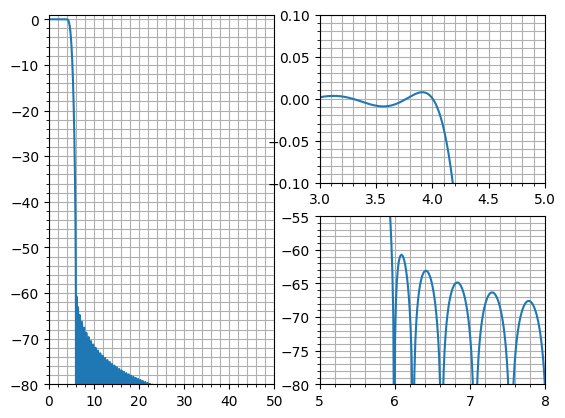

In [174]:
stop_band_attenuation = 60
f_sampling = 100
f_transition = 2
f_minus_6db = 5
low_pass_filter_length = 190 # use 93
num_fft = 1024*8

# h = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
# h = h/sum(h)
h = get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, low_pass_filter_length)
plot_filter_to_verify_spec(h, num_fft, f_sampling)


#### Step 2: Partition the filter tap coefficients to form a ten-path polyphase filter

In [175]:
h_partitioned = np.reshape(h, (19, 10))

#### Step 3: Generate a complex sinusoid with frequencies at 10.5kHz and -22kHz

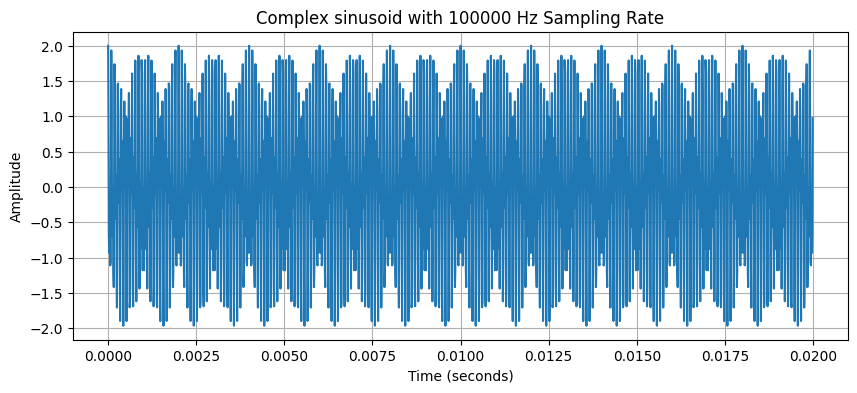

In [180]:
def generate_sinusoid(sample_rate, num_samples):
    # Calculate duration
    # num_samples = int(sample_rate * duration)
    duration = num_samples / sample_rate

    # Create the time axis
    t = np.linspace(0, duration, num_samples, endpoint=False)
    # random_phase = np.random.uniform(0, 2 * np.pi)
    sinusoid = np.exp(1j * 2 * np.pi * 10500 * t) + np.exp(1j * 2 * np.pi * -22000 * t)
    # sinusoid = np.sin(2 * np.pi * frequency * t + random_phase)
    
    return t, sinusoid

# Define parameters for the sinusoid
sampling_rate = 100000   # Hz (must be at least twice the signal_frequency according to Nyquist-Shannon)
number_of_samples = 2000

# Generate the sinusoid
time_axis, signal_data = generate_sinusoid(sampling_rate, number_of_samples)

# Plotting the generated sinusoid
plt.figure(figsize=(10, 4))
plt.plot(time_axis, (signal_data))
plt.title(f'Complex sinusoid with {sampling_rate} Hz Sampling Rate')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
# plt.xlim(0, 0.001)
plt.show()



#### Step 4: pass the complex sinusoid into the polyphase filter to form 10 polyphase path

In [189]:
signal_data_reshaped = np.reshape(signal_data, (200,10))

first_path_result = np.convolve(signal_data_reshaped[:,9], h_partitioned[:,0])
second_path_result = np.convolve(signal_data_reshaped[:,8], h_partitioned[:,1])
third_path_result = np.convolve(signal_data_reshaped[:,7], h_partitioned[:,2])
forth_path_result = np.convolve(signal_data_reshaped[:,6], h_partitioned[:,3])
fifth_path_result = np.convolve(signal_data_reshaped[:,5], h_partitioned[:,4])
sixth_path_result = np.convolve(signal_data_reshaped[:,4], h_partitioned[:,5])
seventh_path_result = np.convolve(signal_data_reshaped[:,3], h_partitioned[:,6])
eighth_path_result = np.convolve(signal_data_reshaped[:,2], h_partitioned[:,7])
ninth_path_result = np.convolve(signal_data_reshaped[:,1], h_partitioned[:,8])
tenth_path_result = np.convolve(signal_data_reshaped[:,0], h_partitioned[:,9])
#out = first_path_result+second_path_result+third_path_result+forth_path_result+fifth_path_result

print("signal_data_reshaped shape", signal_data_reshaped.shape)
print("h_partitioned shape", h_partitioned.shape)
print("first_path_result shape", first_path_result.shape)

signal_data_reshaped shape (200, 10)
h_partitioned shape (19, 10)
first_path_result shape (218,)


#### Step 5: Transform the time series from two paths and identify the spectral aliases. 

(-40.0, 40.0)

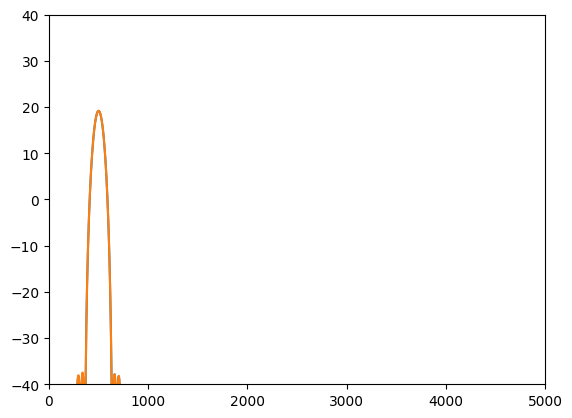

In [190]:
ff = np.arange(0, 1, 1/(4096*8))*10000
plt.figure()
plt.plot(ff, 20*np.log10(abs(np.fft.fft(first_path_result * np.blackman(218), 4096*8))))
plt.plot(ff, 20*np.log10(abs(np.fft.fft(seventh_path_result * np.blackman(218), 4096*8))))
plt.xlim(0, 5000)
plt.ylim(-40, 40)

#### Step 6: Perform the FFT on the polyphase vector sequences to form the 10 phase corrected time series that correspond to the channelized filter bank

In [191]:
output_channels = np.zeros((len(first_path_result), 10), dtype=np.complex128)
# dumb way of doing it
# output_channel_1 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_2 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_3 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_4 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_5 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_6 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_7 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_8 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_9 = np.zeros(len(first_path_result), dtype=np.complex128)
# output_channel_10 = np.zeros(len(first_path_result), dtype=np.complex128)
for i in range(len(first_path_result)):
    vector_to_fft = np.array([first_path_result[i], second_path_result[i], third_path_result[i], forth_path_result[i], fifth_path_result[i], sixth_path_result[i], seventh_path_result[i], eighth_path_result[i], ninth_path_result[i], tenth_path_result[i]])
    fft_outputs = np.fft.ifft(vector_to_fft, 10)
    for j in range(10):
        output_channels[i, j] = fft_outputs[j]
    # dumb way of doing it
    # output_channel_1[i] = channel_outputs[0]
    # output_channel_2[i] = channel_outputs[1]
    # output_channel_3[i] = channel_outputs[2]    
    # output_channel_4[i] = channel_outputs[3]
    # output_channel_5[i] = channel_outputs[4]
    # output_channel_6[i] = channel_outputs[5]
    # output_channel_7[i] = channel_outputs[6]    
    # output_channel_8[i] = channel_outputs[7]
    # output_channel_9[i] = channel_outputs[8]
    # output_channel_10[i] = channel_outputs[9]
print(output_channels[:,1].shape)

(218,)


#### Step 7: Plot the real part and the imaginary part of each time series in a set of subplots

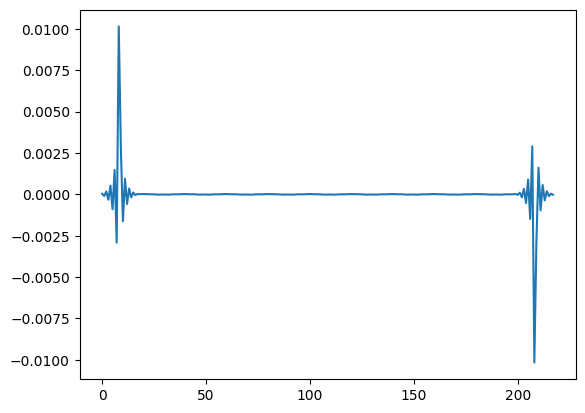

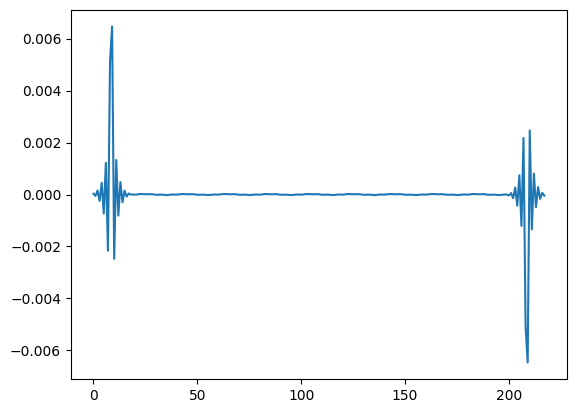

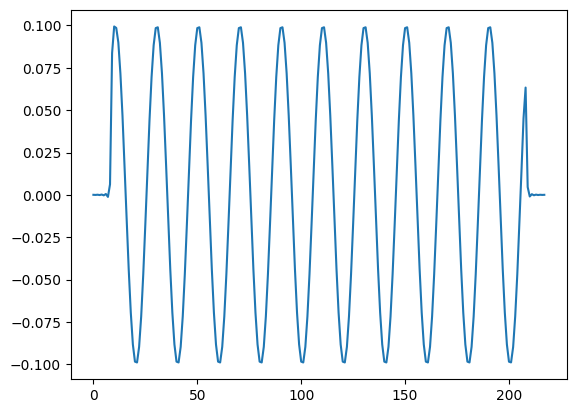

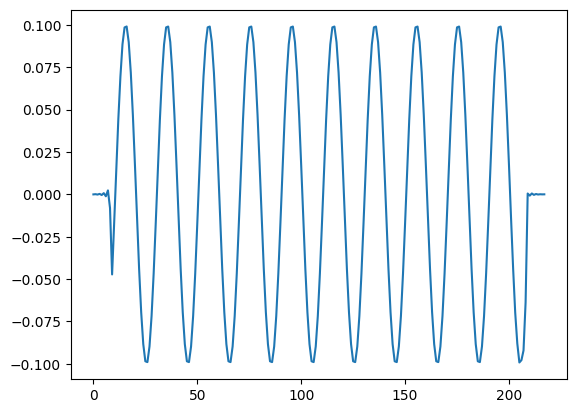

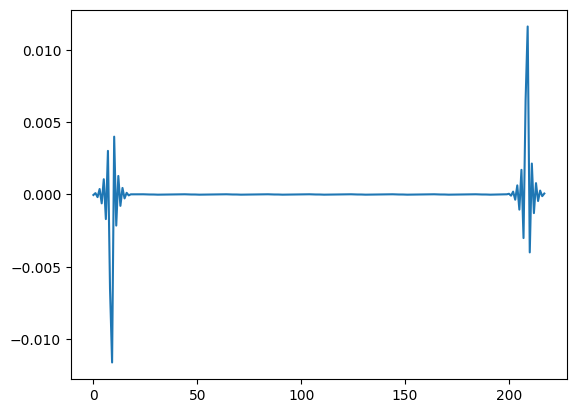

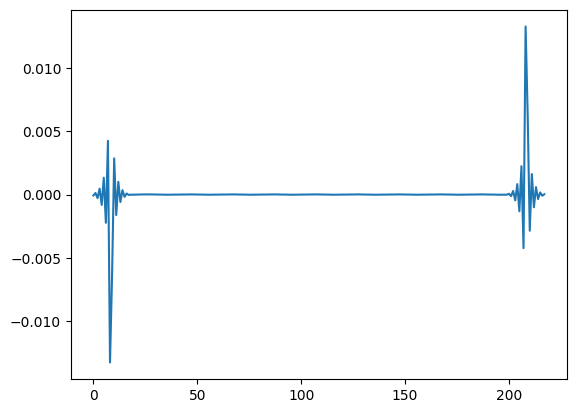

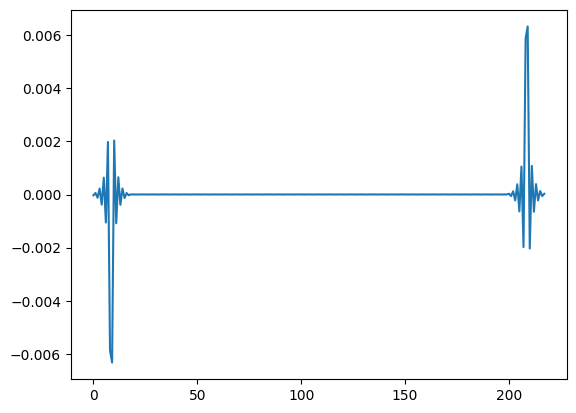

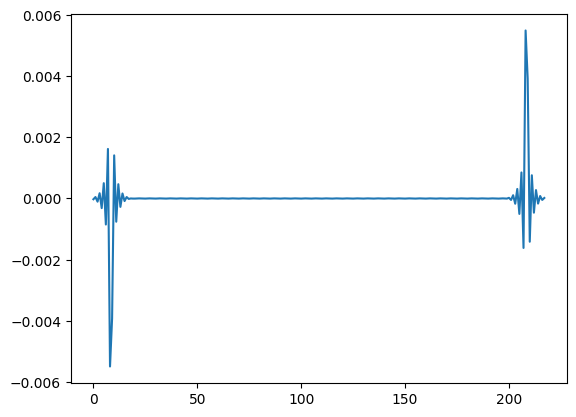

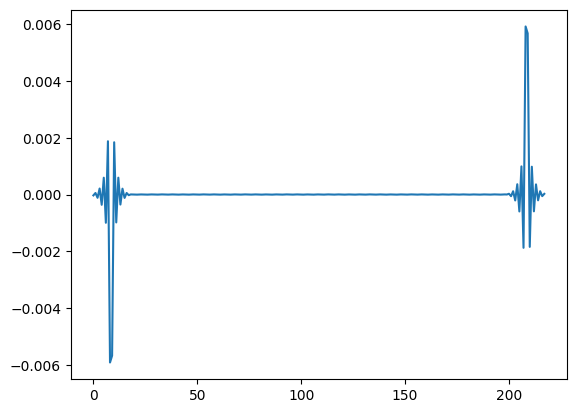

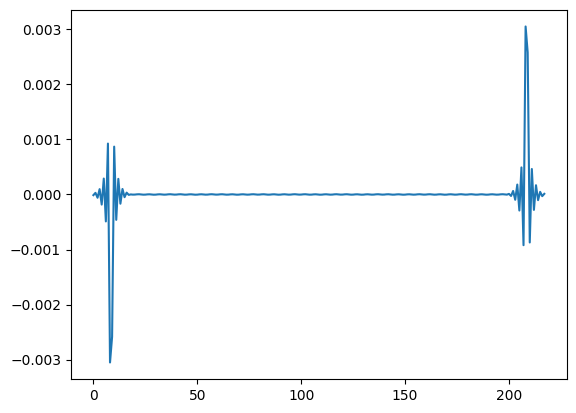

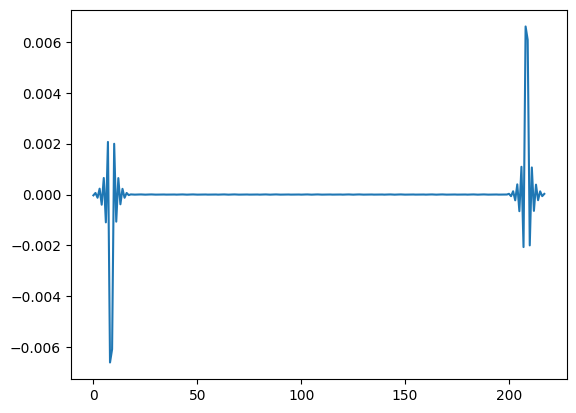

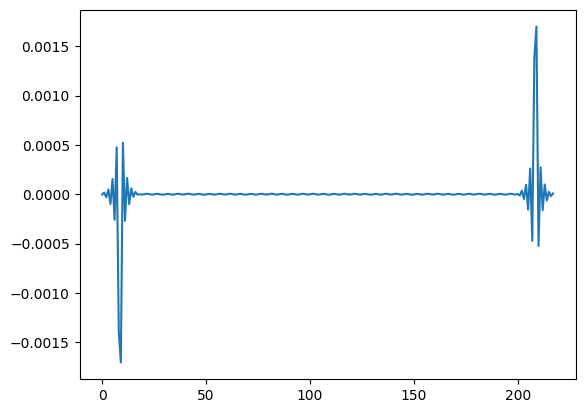

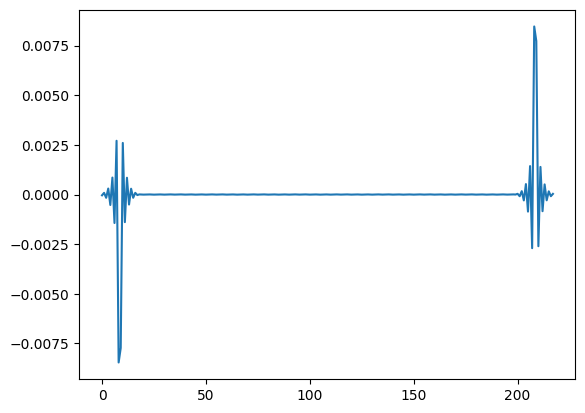

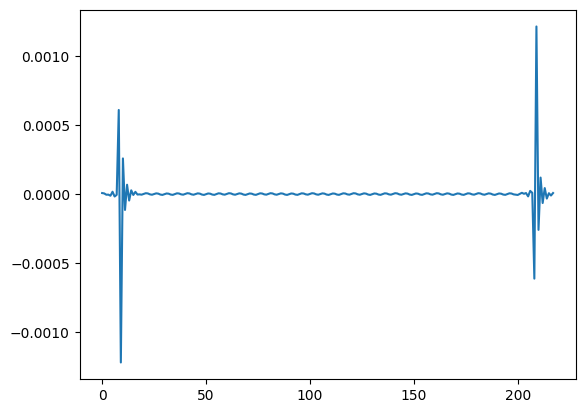

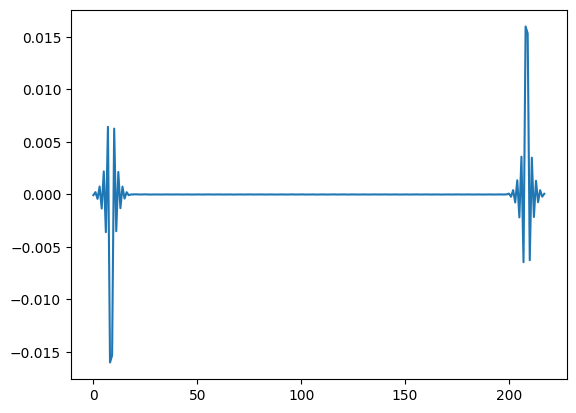

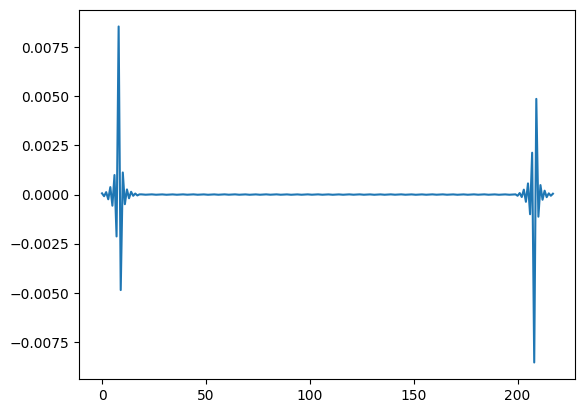

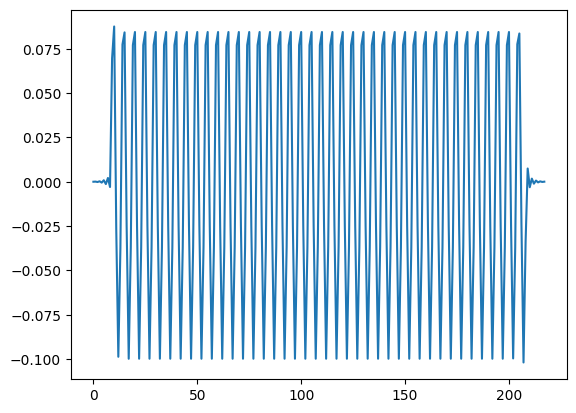

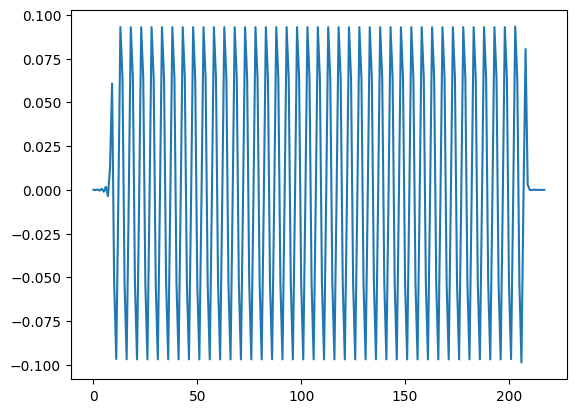

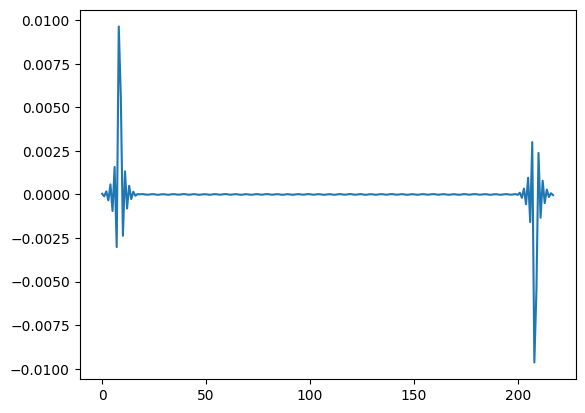

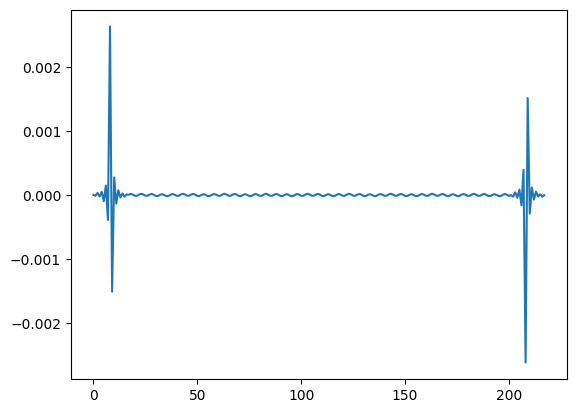

In [192]:
for i in range(10):
    plt.figure()
    plt.plot(np.real(output_channels[:, i]))
    plt.figure()
    plt.plot(np.imag(output_channels[:, i]))


#### Step 8: Form and plot the windowed FFT of the 10 time series

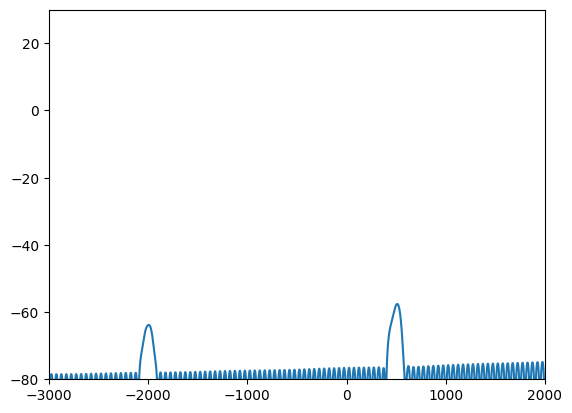

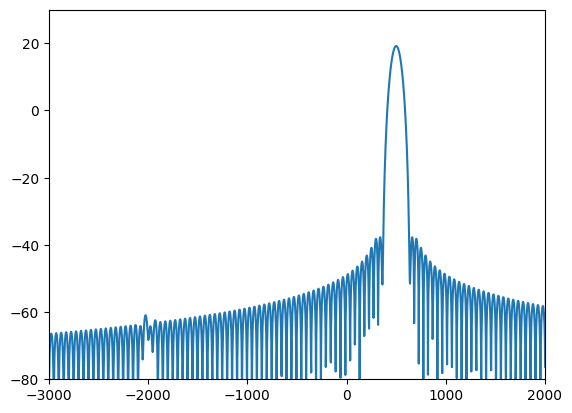

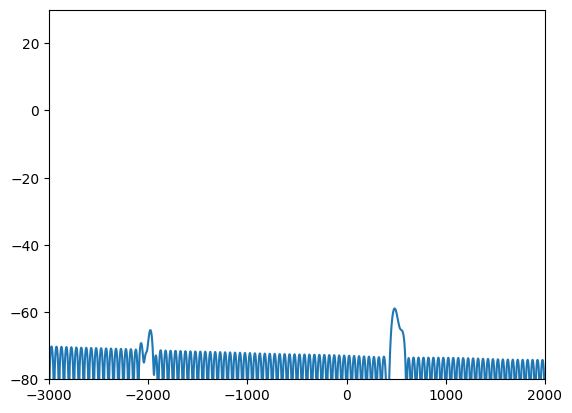

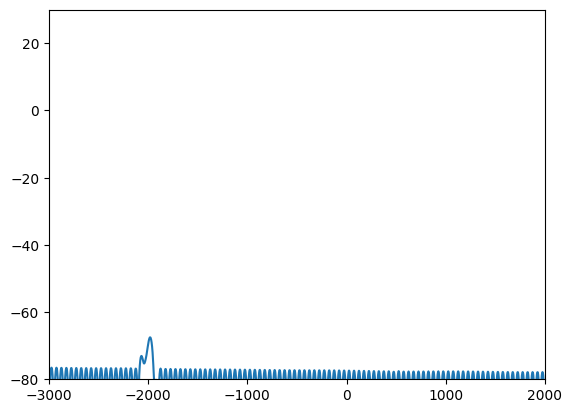

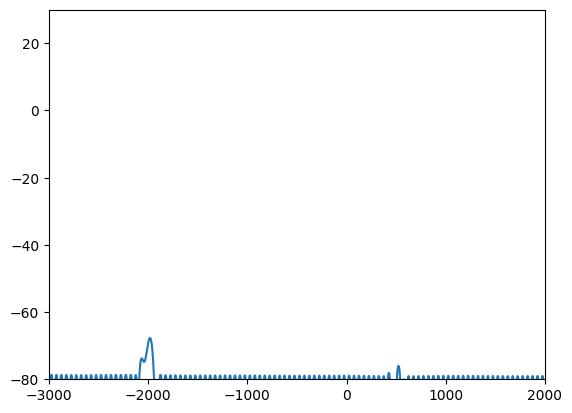

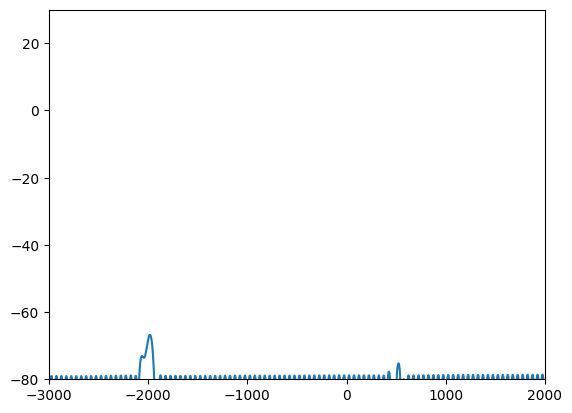

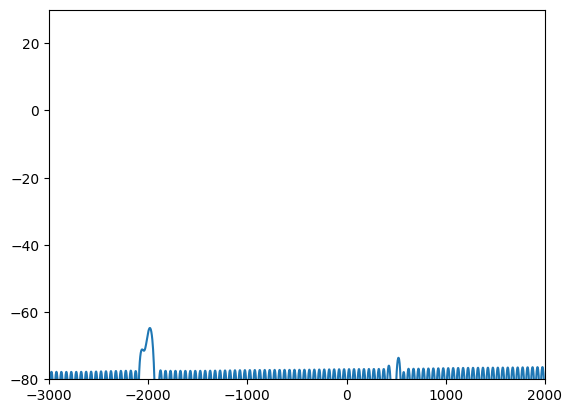

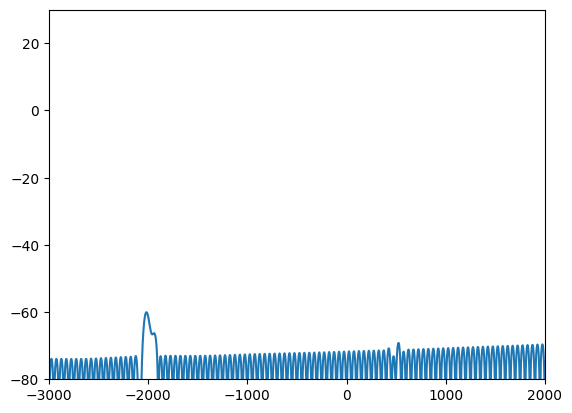

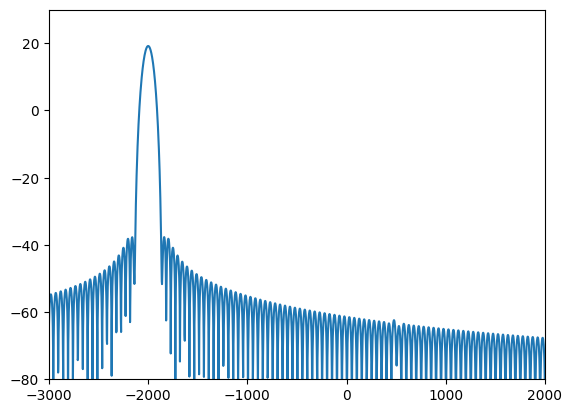

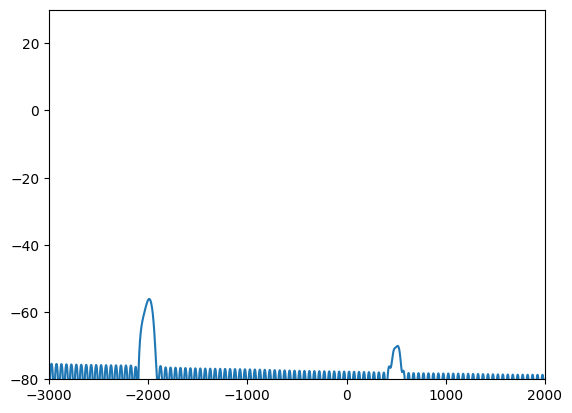

In [193]:
ff = np.arange(-0.5, 0.5, 1/4096) * 10000
for i in range(10):
    plt.figure()
    plt.plot(ff, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(output_channels[:, i] * np.blackman(218), 4096)))))
    plt.ylim(-80, 30)
    plt.xlim(-3000, 2000)